In [1]:
# !pip3 install box2d-py
# !pip3 install gym[Box_2D]
# %pip install ribs[all] gym~=0.17.0 Box2D~=2.3.10 tqdm


In [2]:
import gym
import numpy as np
import random
import time 
import matplotlib.pyplot as plt
from collections import namedtuple

import torch
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# plotting
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [3]:
env = gym.make("LunarLander-v2")
print(env.action_space) #[Output: ] Discrete(2)
print(env.observation_space) # [Output: ] Box(4,)


Discrete(4)
Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)


In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [5]:
class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def save_transition(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = T.from_numpy(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = T.from_numpy(next_state)
        
        action_tensor = T.tensor([action], device=device).unsqueeze(0)

        reward = T.tensor([reward], device=device).unsqueeze(0)/10. # reward scaling

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)  # save the transition
        self.position = (self.position + 1) % self.capacity  # loop around memory

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
#https://github.com/Curt-Park/rainbow-is-all-you-need

# if gpu is to be used
device = T.device("cuda" if T.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        super(DQN,self).__init__()

        # Dueling common layer
        self.feature_layer = nn.Sequential(
            nn.Linear(input_size, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, size_hidden),
            nn.ReLU()
        )
        # set advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(size_hidden, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden, output_size)
        )

        # set value layer
        self.value_layer = nn.Sequential(
            nn.Linear(size_hidden, size_hidden),
            nn.ReLU(),
            nn.Linear(size_hidden,1)
        )
    def forward(self, x):

      feature = self.feature_layer(x)
      
      value = self.value_layer(feature)
      advantage = self.advantage_layer(feature)

      output = value + advantage - advantage.mean(dim=-1, keepdim=True)
      return output

In [14]:
OBS_SIZE = 8
HIDDEN_SIZE = 64
ACTION_SIZE = 4

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 20

optimizer = optim.Adam(Q_network.parameters(), lr=0.001)
memory = ReplayMemory(5000)

In [15]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        if is_greedy :
            # we select greedy action
            with T.no_grad():
                Q_network.eval()
                index_action = Q_network(state).argmax().detach().cpu().numpy().item()  # state is on cpu instead of GPU!
                Q_network.train()

        else:
            # we sample a random action
            index_action = env.action_space.sample() # select random action (4 possible values)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start

In [16]:
policy = E_Greedy_Policy(epsilon=0.5, decay=0.997, min_epsilon=0.001)
BATCH_SIZE = 64
GAMMA = 0.99

def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = T.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=T.bool)
    non_final_next_states = T.cat([s for s in batch.next_state if s is not None])
    non_final_next_states = T.reshape(non_final_next_states, (non_final_mask.sum(), -1)).float().to(device)  # Reshape to (nr. non final, 8)

    state_batch = T.cat(batch.state).float().to(device)  # .float().to(device) to move to GPU
    state_batch = T.reshape(state_batch, (BATCH_SIZE, -1))  # Reshape to (batch_size, 8)
    action_batch = T.cat(batch.action).to(device)
    reward_batch = T.cat(batch.reward).float().to(device)
  

        # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)

    # Compute next Q values using Q_targets
    next_Q_values = T.zeros( BATCH_SIZE, device=device).to(device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    next_Q_values = next_Q_values.unsqueeze(1)

       # Compute targets
    target_Q_values = (next_Q_values * GAMMA) + reward_batch
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    for param in Q_network.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [17]:


env = gym.make("LunarLander-v2")  # create environment

num_episodes = 2
policy.reset()
rewards_history = []

# Warmup phase!
memory_filled = False
print("Warmup phase...")
while not memory_filled:
    
    state = env.reset()  # 8 states: coordinates of the lander (x,y), linear velocities (x,y), angle, angular velocity, 2 bools if each leg is touches ground.
    done = False
    total_reward = 0
    
    while not done:  # for each episode
        # Get action and act in the world
        state_tensor = T.from_numpy(state).float().to(device)
        action = policy(state_tensor)  # <<--- choose greedy (choose index of highest q-value predicted by network) or exploration
        next_state, reward, done, __ = env.step(action)
        total_reward += float(reward)
        

               # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.save_transition(state, action, next_state, float(reward))
        state = next_state

    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
for i_episode in range(num_episodes):
    # New dungeon at every run
    state = env.reset()
    done = False
    total_reward = 0
    
    
    while not done:  # iterate through states
        
        # Get action and act in the world
        state_tensor = T.from_numpy(state).float().to(device)  # <<--- convert state to tensor and move to GPU
        
        action = policy(state_tensor)   # choose greedy (index of q-value predictions) or exploration
        next_state, reward, done, __ = env.step(action)
        total_reward += float(reward)


                # Observe new state
        if done:
            next_state = None
        memory.save_transition(state, action, next_state, float(reward))  # Store the transition in memory
        state = next_state  # Move to the next state

        # Perform one step of the optimization
        #started_training = True
        loss = optimize_model()

    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_network.state_dict())
    
    if i_episode % 10 == 0:
        avg_rewards_10 = sum(rewards_history[-10:])/10

        print('Episode {} - reward: {:.3f}, avg. reward (past 10 ep.): {:.3f}, eps: {:.3f} loss: {:.3f} '.format(
            i_episode, total_reward, avg_rewards_10, policy.epsilon, loss))   
    
print('Complete')

Warmup phase...
Done with the warmup
Episode 0 - reward: -153.144, avg. reward (past 10 ep.): -15.314, eps: 0.498 loss: 0.119 
Complete


ValueError: ignored

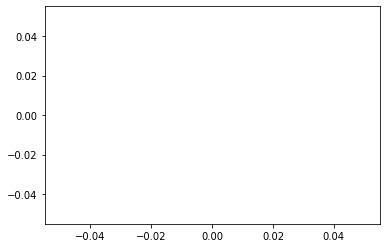

In [89]:
plt.plot(rewards_history, '-')
# add 100 episode moving average
avg_rewards_history = np.convolve(rewards_history, np.ones((100,))/100, mode='valid')
plt.plot(avg_rewards_history, '-')
plt.title('Rewards')
plt.show()

NameError: ignored